# Analytic solution for $T \to 0$
xumerical solutiox of probability distribution $P(a)$ obtained from Fokker Planck 

this may need an analysis function similar to the ML code because the evaluation of the evaluation of the P(A) may be challenging

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.simulation import *
from src.approximation import *
from src.theory import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [2]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1000 # random seed 
}
params['epsilon'] = 0.1
params['sigma'] = 0.01
params['window'] = 1
dt = 1 #fixed time step

## Solution from (mean-field coupled) Fokker Planck equation 

In [3]:
def fp_solution(support, f, g):
    def integrand(x):
        return f(x) / g(x)

    exponent = lambda x: 2 * scipy.integrate.quad(integrand, 0, x)[0]
    exponent = np.vectorize(exponent)
    log_pmf = exponent(support) - np.log(g(support)) # + np.log(g(0)) # in principle there would be another g(0) from the integration of gamma

    pmf = np.exp(log_pmf - np.max(log_pmf))
    # normalize the pmf
    pmf = pmf / np.sum(pmf)
    return pmf


def fp_pmf_rest(params, h, lam):
    x_max = params["N"] * (1 - params["mu"])
    support = np.arange(0, x_max + 1)

    if lam == 0:
        # in this case the rest cannot receive ANY input and hence the pdf is a delta distribution
        pmf = np.zeros_like(support)
        pmf[0] = 1
        return support, pmf

    # probability of external activation
    p_ext = 1 - np.exp(-h * dt)

    # A_in = (
    #     lambda x: params["mu"]
    #     * (params["N"] * p_ext + lam * (1 - p_ext) * x)
    #     / (1 - params["mu"] * lam * (1 - p_ext))
    # )
    # p_rec = lambda x: lam * (A_in(x) + x) / params["N"]
    # alternative formulation
    p_rec = (
        lambda x: lam
        * (x / params["N"] + params["mu"] * p_ext)
        / (1 - params["mu"] * lam * (1 - p_ext))
    )

    # spikes generates with rate (N^{rest} - x^{rest]) * p_rec(x^{rest})
    rate_birth = lambda x: (x_max - x) * p_rec(x)
    # spikes not maintined with rate x^{rest} * (1 - p_rec(x^{rest}))
    rate_death = lambda x: x * (1 - p_rec(x))

    f = lambda x: rate_birth(x) - rate_death(x)
    g = lambda x: rate_birth(x) + rate_death(x)

    return support, fp_solution(support, f, g)


def fp_pmf_input(params, h, lam):
    x_max = params["N"] * params["mu"]
    support = np.arange(0, x_max + 1)

    # probability of external activation
    p_ext = 1 - np.exp(-h * dt)

    # A_rest = lambda x: (1 - params["mu"]) * lam * x / (1 - (1 - params["mu"]) * lam)
    # p_rec = lambda x: lam * (x + A_rest(x)) / params["N"]
    # alternative formulation
    p_rec = lambda x: lam * x / params["N"] / (1 - (1 - params["mu"]) * lam)

    # NEW spikes generated from inactive neurons: (N^{input} - x^{input])
    # with probability of not being not activated: (1 - (1-p_rec)*(1-p_ext) )
    rate_birth = lambda x: (x_max - x) * (1 - (1 - p_rec(x)) * (1 - p_ext))
    # REMOVE spikes only if active neurons: x^{input}
    # are not activated with probability (1 - p_rec) * (1 - p_ext)
    rate_death = lambda x: x * (1 - p_rec(x)) * (1 - p_ext)

    f = lambda x: rate_birth(x) - rate_death(x)
    g = lambda x: rate_birth(x) + rate_death(x)

    # catch case of super strong drive that results in g==0 at x_max implying that the pmf is a delta distribution
    if g(x_max) == 0:
        pmf = np.zeros_like(support)
        pmf[-1] = 1
        return support, pmf, rate_birth(support), rate_death(support)

    return support, fp_solution(support, f, g), rate_birth(support), rate_death(support)

In [4]:
?pmf_from_coupled_fokker_planck

Signature: pmf_from_coupled_fokker_planck(params, h, lam)
Docstring:
Solution to the Mean-field coupled Fokker-Planck equations. 
1.1) compute solution of FP equation of the part that receives input assuming a mean-field coupling to the recurrently coupled rest
ight)}$$
from mean-field assumption
$$ x_rest = rac{(1-\mu)\lambda x_in}{1-(1-\mu)\lambda}$$ 

1.2) compute solution of FP equation for the part that does not receive input assuming a mean-field coupling to the input part
ight)}$$
with 
$$ x_in = \murac{N p_\mathrm{ext} + \lambda (1-p_\mathrm{ext}) x_\mathrm{rest}}{1-\mu\lambda(1-p_\mathrm{ext})} $$
2) convolution of the two solutions to obtain the full pmf
File:      ~/git/projects/sahel_finite-observation-dynamic-range/src/theory.py
Type:      function

## Test for $\lambda=0$ essentially recovering the external noise distribution

In [5]:
# reference simulation to compare with (lamdba=0 case)
N=int(1e4)
K=100
h = 1e-1
mu=0.2
dt=1
# recurrent coupling fixed
lambda_ = 0.0
w = coupling_weights(N, K, lambda_, seed=1234)

# run self-build simulations
T = 10000
T_burn = 1000
rng = np.random.default_rng(1234)
p_h = external_spiking_probability(N, mu, h, seed=1234, dt=1)
activity = np.zeros(T)
x = np.zeros(N)
activity_smooth = np.zeros(T)
alpha = 1 - np.exp(-dt / 1)
for t in range(T):
    x = step(x, w, p_h, rng)
    activity[t] = np.sum(x)
    if t > 0:
        activity_smooth[t] = (1 - alpha) * activity_smooth[t - 1] + alpha * activity[t]  

# throw away burn in
activity = activity[T_burn:]
activity_smooth = activity_smooth[T_burn:]

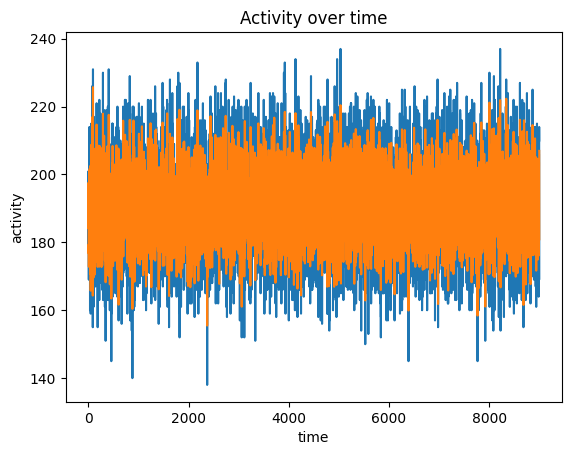

In [6]:
# plot activity
plt.plot(activity[:])
plt.plot(activity_smooth[:])
plt.xlabel('time')
plt.ylabel('activity')
plt.title('Activity over time')
plt.show()

In [7]:
# sample isolated neurons driven by Poissin noise
p_ext = 1 - np.exp(-h)
num_samples=100000
data_poisson = np.zeros(num_samples)
for i in range(num_samples):
    data_poisson[i] = np.sum(np.random.random(size=int(params["mu"]*params["N"])) < p_ext)

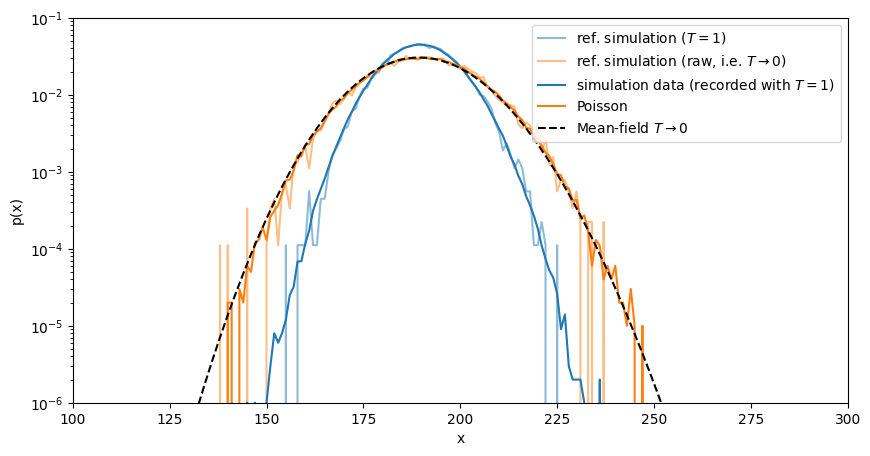

In [9]:
# plot
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes=[axes]

# distribution from acitivty_smooth
dist = np.histogram(activity_smooth[:], bins=np.arange(0, params["mu"]*params["N"]+1), density=True)[0]
axes[0].plot(np.arange(0, params["mu"]*params["N"]), dist, label=r"ref. simulation ($T=1$)", alpha=0.5, color='C0')

# distribution from acitivty
dist = np.histogram(activity[:], bins=np.arange(0, params["mu"]*params["N"]+1), density=True)[0]
axes[0].plot(np.arange(0, params["mu"]*params["N"]), dist, label=r"ref. simulation (raw, i.e. $T\to 0$)", alpha=0.5, color='C1')

# get distribution from simulation
filename="/Users/johannes/git/projects/sahel_finite-observation-dynamic-range/dat/example_simulation/example_sim_N=10000_K=100_seed=1000_1-lambda=1.00e+00_mu=0.20_h=1.00e-01.h5"
import h5py
with h5py.File(filename, "r") as f:
    data = np.array(f['samples/1.0'])
    support = np.arange(0, params["mu"]*params["N"])
    dist = np.histogram(data*params["N"], bins=np.append(support, support[-1]+1), density=True)[0]
    # plot
    axes[0].plot(support, dist, label=r"simulation data (recorded with $T=1$)")

# plot distribution
support = np.arange(0, params["mu"]*params["N"])
dist = np.histogram(data_poisson, bins=np.append(support, support[-1]+1), density=True)[0]
axes[0].plot(support, dist, label=r"Poisson")

# Mean-field solution
x, pmf_fp = pmf_from_coupled_fokker_planck(params, h=1e-1, lam=0.0)
axes[0].plot(x, pmf_fp, label=r'Mean-field $T\to 0$', color='black', linestyle='--')

# estimate solution for $T=1$ from smoothening kernel?

axes[0].set_xlabel('x')
axes[0].set_ylabel('p(x)')
axes[0].set_yscale('log')
axes[0].set_ylim(bottom=1e-6, top=0.1)
axes[0].set_xlim(100,300)
axes[0].legend()
plt.show()


## Compare for special cases $\lambda$

(5500.0, 7500.0)

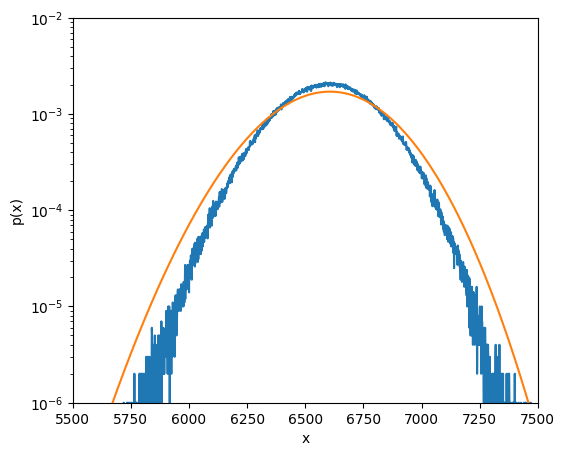

In [10]:
# plot
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
axes = [axes]

# get distribution from simulation
filename="/Users/johannes/git/projects/sahel_finite-observation-dynamic-range/dat/example_simulation/example_sim_N=10000_K=100_seed=1000_1-lambda=1.00e-02__mu=0.20_h=1.00e-01.h5"
import h5py
with h5py.File(filename, "r") as f:
    data = np.array(f['samples/1.0'])
    support = np.arange(0, params["N"])
    dist = np.histogram(data*params["N"], bins=np.append(support, support[-1]+1), density=True)[0]
    # plot
    axes[0].plot(support, dist, label="simulation")

# analytical solution
h=1e-1
lam=0.99
x, pmf = pmf_from_coupled_fokker_planck(params, h=h, lam=lam)
# plot
axes[0].plot(x, pmf, label="Mean-field")

# # convolution with Gaussian (later)
# pmf_norm = stats.norm.pdf(support, 0, params["sigma"])
# pmf_conv_gauss = np.convolve(pmf_conv, pmf_norm, mode='same')

axes[0].set_xlabel('x')
axes[0].set_ylabel('p(x)')
axes[0].set_yscale('log')
axes[0].set_ylim(bottom=1e-6, top=0.01)
axes[0].set_xlim(5500, 7500)

lam=0


100%|██████████| 5/5 [00:00<00:00, 184.62it/s]


lam=0.99


100%|██████████| 5/5 [00:00<00:00, 261.08it/s]


lam=0.9999


100%|██████████| 5/5 [00:00<00:00, 262.25it/s]


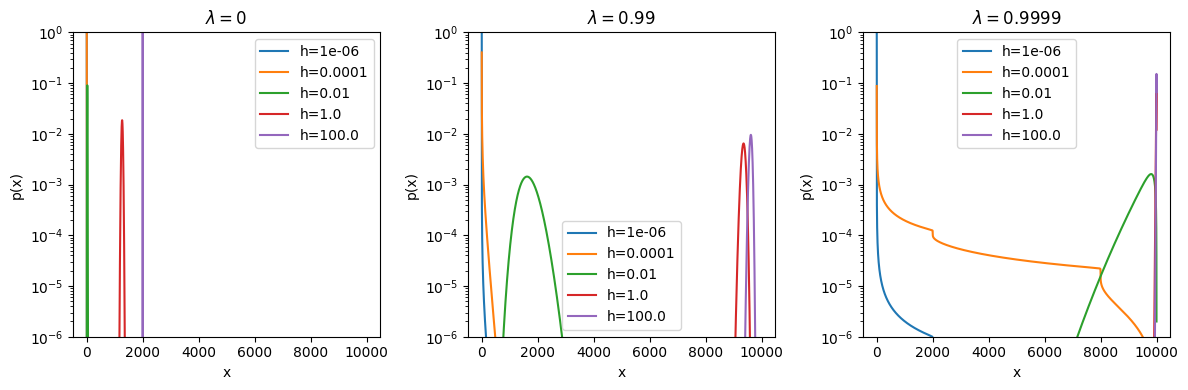

In [11]:
from tqdm import tqdm
# plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# analytical solution (lam=0, lam=0.99, lam=0.9999)
for i,lam in enumerate([0, 0.99, 0.9999]):
    print(f"lam={lam}")
    axes[i].set_title(f"$\lambda={lam}$")
    for h in tqdm([1e-6, 1e-4, 1e-2, 1e-0, 1e2]):
        x, pmf = pmf_from_coupled_fokker_planck(params, h=h, lam=lam)
        axes[i].plot(x, pmf, label="h="+str(h))
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('p(x)')
    axes[i].set_yscale('log')
    axes[i].set_ylim(bottom=1e-6, top=1)
    axes[i].legend()
plt.tight_layout()

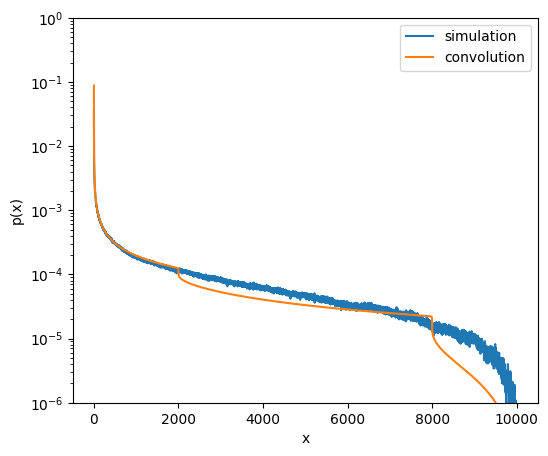

In [12]:
lam = 0.9999
h = 1e-4
# plot data
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
filename=f"/Users/johannes/git/projects/sahel_finite-observation-dynamic-range/dat/example_simulation/example_sim_N=10000_K=100_seed=1000_1-lambda={1-lam:.2e}__mu=0.20_h={h:.2e}.h5"
with h5py.File(filename, "r") as f:
    data = np.array(f['samples/1.0'])
    support = np.arange(0, params["N"])
    dist = np.histogram(data*params["N"], bins=np.append(support, support[-1]+1), density=True)[0]
    # plot
    axes.plot(support, dist, label="simulation")

# analytical solution
# x_input, pmf_input, b,d = fp_pmf_input(params, h=h, lam=lam)
# x_rest, pmf_rest = fp_pmf_rest(params, h=h, lam=lam)
# # plot both distributions
# axes.plot(x_input, pmf_input, label="input")
# axes.plot(x_rest, pmf_rest, label="rest")
# # convolution
# pmf_conv = np.convolve(pmf_input, pmf_rest, mode='full')
x, pmf = pmf_from_coupled_fokker_planck(params, h=h, lam=lam)
# plot
axes.plot(x, pmf, label="convolution")
axes.set_xlabel('x')
axes.set_ylabel('p(x)')
axes.set_yscale('log')
axes.set_ylim(bottom=1e-6, top=1)
axes.legend()
plt.show()

# Determine discriminable inputs and compare to result from beta approximation

In [13]:
lam = 0.99

In [14]:
#timing test for one lambda analysis
support_bound = int(params["N"]*(1 + 4 * params["sigma"]))
support_fp = np.arange(-support_bound, support_bound+1)
pmf_fp = np.zeros_like(support_fp, dtype=np.float64)
pmf_fp_norm = stats.norm.pdf(support_fp, 0, params["N"]*params["sigma"])
def pmf_fp_o_given_h(h):
    x, pmf = pmf_from_coupled_fokker_planck(params, h=h, lam=lam)
    # set pmf where support == x
    mask = np.where(np.isin(support_fp, x))
    pmf_fp[mask] = pmf
    # convolution with a Gaussian distribution at every point of the support
    return np.convolve(pmf_fp, pmf_fp_norm, mode="same")

In [15]:
x, pmf = pmf_from_coupled_fokker_planck(params, h=1e-1, lam=lam)
pmf_smooth = pmf_fp_o_given_h(1e-1)

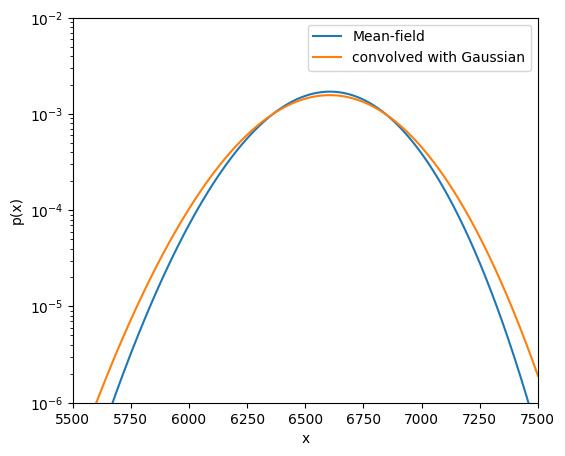

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
axes.plot(x, pmf, label="Mean-field")
axes.plot(support_fp, pmf_smooth, label="convolved with Gaussian")
axes.set_xlabel('x')
axes.set_ylabel('p(x)')
axes.set_yscale('log')
axes.set_ylim(bottom=1e-6, top=1e-2)
axes.legend()
axes.set_xlim(5500, 7500)
plt.show()

In [19]:
fp_pmf_ref_left = stats.norm.pdf(
    support_fp,
    params["N"] * mean_field_activity(lam, params["mu"], h=0),
    params["N"] * params["sigma"],
)
fp_pmf_ref_right = stats.norm.pdf(
    support_fp,
    params["N"] * mean_field_activity(lam, params["mu"], h=np.inf),
    params["N"] * params["sigma"],
)
fp_pmf_refs = [fp_pmf_ref_left, fp_pmf_ref_right]

In [20]:
h_range = [1e-6, 1e2]
hs_left = find_discriminable_inputs(
    pmf_fp_o_given_h, h_range, fp_pmf_refs, params["epsilon"], verbose=True, start="left"
)

possible solution: h=0.0017584030900865625 with overlap to end of 5.761641439940293e-86 ... accepted
possible solution: h=0.004767098644492052 with overlap to end of 3.488545150658333e-77 ... accepted
possible solution: h=0.009211181123983095 with overlap to end of 2.990202308011919e-68 ... accepted
possible solution: h=0.015331963858350285 with overlap to end of 1.9365214719233596e-59 ... accepted
possible solution: h=0.023475923499418037 with overlap to end of 5.818759176871006e-51 ... accepted
possible solution: h=0.03412773015244635 with overlap to end of 5.770031782407779e-43 ... accepted
possible solution: h=0.047964868328341126 with overlap to end of 1.4827332556519855e-35 ... accepted
possible solution: h=0.06594859295464088 with overlap to end of 8.342985214794583e-29 ... accepted
possible solution: h=0.08948211870642651 with overlap to end of 9.155093516584892e-23 ... accepted
possible solution: h=0.12070300569314454 with overlap to end of 1.82317807157567e-17 ... accepted
po

In [21]:
pmfs_fp = []
for h in hs_left:
    pmf = pmf_fp_o_given_h(h)
    pmfs_fp.append(pmf)

In [24]:
# get discriminable intervals for ml solution
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
beta_interpolation = pd.read_sql_query(
    f"SELECT * FROM beta_interpolations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}",
    con,
)
con.close()
beta_approx = FunctionApproximation(
    filename=beta_interpolation["filename"].values[0]
)

# define pmf from convolution of beta distribution with Gaussian noise
delta = 1 / beta_approx.params["N"]
ml_support = np.arange(0, 1 + 4 * params["sigma"], delta)
ml_support = np.concatenate((-ml_support[::-1], ml_support[1:]))
loc = beta_approx.params["loc"]
scale = beta_approx.params["scale"]

window=1
def ml_pmf_o_given_h(h):
    a, b = beta_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf_beta = np.diff(stats.beta.cdf(ml_support, a, b, loc=loc, scale=scale))
    # convolution with a Gaussian distribution at every point of the support
    pmf_norm = stats.norm.pdf(ml_support, 0, params["sigma"]) * delta
    return np.convolve(pmf_beta, pmf_norm, mode="same")

In [25]:
h_range = [1e-6, 1e2]
ml_pmf_ref_left = ml_pmf_o_given_h(h_range[0])
ml_pmf_ref_right = ml_pmf_o_given_h(h_range[-1])
ml_pmf_refs = [ml_pmf_ref_left, ml_pmf_ref_right]

In [26]:
ml_hs_left = find_discriminable_inputs(
    ml_pmf_o_given_h, h_range, ml_pmf_refs, params["epsilon"], verbose=True, start="left"
)

possible solution: h=0.0016967687521811069 with overlap to end of 6.463065353641314e-273 ... accepted
possible solution: h=0.004439812177502572 with overlap to end of 1.3445936588954048e-225 ... accepted
possible solution: h=0.008261900412721578 with overlap to end of 4.380899188551031e-184 ... accepted
possible solution: h=0.013214496250744544 with overlap to end of 8.075678667377444e-147 ... accepted
possible solution: h=0.019459543384206388 with overlap to end of 1.9229289267793647e-114 ... accepted
possible solution: h=0.02726405210998023 with overlap to end of 1.932092093638427e-87 ... accepted
possible solution: h=0.03700591215509475 with overlap to end of 6.345747260413466e-66 ... accepted
possible solution: h=0.049197806181509623 with overlap to end of 2.368787607333102e-49 ... accepted
possible solution: h=0.06453201081037661 with overlap to end of 4.574049520148276e-37 ... accepted
possible solution: h=0.0839571170488445 with overlap to end of 3.109224187637429e-28 ... accept

In [27]:
ml_pmfs = []
for h in hs_left:
    pmf = ml_pmf_o_given_h(h)
    ml_pmfs.append(pmf)

(-0.04, 1.01)

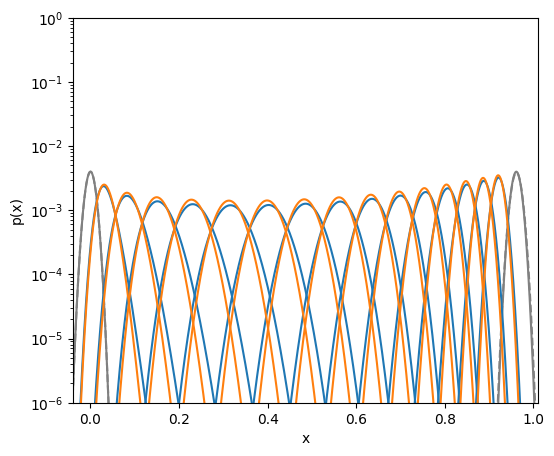

In [28]:
# plot distributions that were identified
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
axes.plot(support_fp/params["N"], fp_pmf_refs[0], label="references", color='gray')
axes.plot(support_fp/params["N"], fp_pmf_refs[1], color='gray')
axes.plot(ml_support, ml_pmf_refs[0], color='gray', linestyle='--')
axes.plot(ml_support, ml_pmf_refs[1], color='gray', linestyle='--')
for pmf in pmfs_fp:
    axes.plot(support_fp/params["N"], pmf, label=f"h={h}", color='C0')
for pmf in ml_pmfs:
    axes.plot(ml_support, pmf, label=f"sim", color='C1')
axes.set_xlabel('x')
axes.set_ylabel('p(x)')
axes.set_yscale('log')
axes.set_ylim(bottom=1e-6, top=1)
axes.set_xlim(-4*params["sigma"],1+params["sigma"])